<a href="https://colab.research.google.com/github/myrronaguila/analyze_sqc/blob/main/qutip%20Bloch%20Sphere%20Animation/2Q_Gates_CNOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bloch Sphere Animation - 2Q Gates (CNOT)
By Myrron Albert Callera Aguila, PhD (First updated 20231025)

## Disclaimer:
Our codes are using only 1Q gates for visualization of said operation. This code base does not yet deal with 2Q circuit gates which requires more-precise evolution based on Unitary Matrix. However, this can be done in its advanced form once the matrix crunching is done properly.

##Imported Libraries

In [ ]:
#Python library installed #34 seconds
!pip install qutip==4.7.3     # for quantum operations => 4.7.3
!pip install qutip-qip==0.3.0 # extension of quantum operations => 0.3.0

!pip install ghostscript==0.7 # for showing transpiler => 0.7
!pip install folium==0.2.1 #error; folium-0.14.0 = org
!pip install pdflatex==0.1.3 #=> 0.1.3

#for mp4 animation
!apt install ffmpeg    # for qubit animation => 7:4.4.2-0ubuntu0.22.04.1
!apt install imagemagick # for image animation => -6.q16
!apt install pdf2svg #convert pdf2svg for circuit list =>
!sudo apt-get install texlive-latex-recommended #textlive latex => none
!sudo mv /etc/ImageMagick-6/policy.xml /etc/ImageMagick-6/policy.xml.off #needed for qip setup to work
!sudo apt install texlive-latex-extra #data analysis => none
!sudo apt install dvipng #convert qutip image to png without latex =>1.15-1.1

#for imageio method then change from gif to .mp4

!pip install Latex==0.7.0 #install latex for listing plots => 0.7.0
!pip install latextools==0.5.0 #install latextools => 0.5.0
#runtime: 2m 30s

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79793 sha256=720fa3feb73862997084e7430c3c69495d98c2e03772fdc9189078d9e76eb44f
  Stored in directory: /root/.cache/pip/wheels/00/0c/07/d7792a5444d5bb074361ac27da53cee9d5cce59a07fe9da5dd
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.14.0
    Uninstalling folium-0.14.0:
      Successfully uninstalled folium-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.17.6 requires folium>=0.9.1, but you have folium 0.2.1 which is incompatible.
geemap 0.28

In [ ]:
#imported libraries
#computational commands for imported plots
import numpy as np
import scipy
import qutip

#showing installed components
import inspect #useful for printing python modules uploaded
import sys #for printing imported python modules and versions
#runtime = 2m 31s

# perform animation of gate rotation
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [ ]:
#imported classes from libraries
from functools import partial #useful

#Activate 3D projection
from mpl_toolkits.mplot3d import Axes3D #activate 3D projection on Bloch Sphere

# basis of setting states in Qutip, refer to https://qutip.org/docs/latest/guide/guide-basics.html
# single-qubit gate operation, refer to https://qutip.org/docs/latest/guide/qip/qip-basics.html
from qutip import basis, Qobj, sigmax, sigmay, sigmaz, tensor, expect

from IPython.display import Image # https://github.com/qutip/qutip-qip/issues/64

#from qutip.qip.circuit import QubitCircuit, Gate
from qutip_qip.circuit import QubitCircuit
#add rotation operators for phi and theta - useful for making trajectories
#https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.operations.html#qutip_qip.operations.rotation
from qutip_qip.operations import RX, RY, RZ, Gate #for 1Q gate rotations
from qutip.qip import hadamard_transform #Hadamard evolution

## Important Library

Extract Qubit State

In [ ]:
# no change from 20230928
def extract_state_info_qt(init_state):
  """
  20230926 Data analysis
  Extract appropriate qutip parameters using qt.expect
  # no good analysis if theta and phi have flawed database
  Get coordinates from state. To simplify, we get the theta and phi after
  state readout.
  Input
    init_state: Qobj
      state preparation
    norm: string
      norm='Y' => normalized to unit vector
      norm='N' => get raw state
  Output:
    dict_info: dictionary
      dict_info[0]: list of floats in coordinates
        [u, v, w]
      dict_info[1]: list of floats in radians
        [theta, phi]
      dict_info[2]: list of floats in fractions
        [alpha**2, beta**2]
  """
  #assess whether normalization is important
  alpha, beta = init_state.full().flatten()
  if (np.abs((alpha*np.conj(alpha))) + np.abs((beta*np.conj(beta)))) > 1:
    init_state = init_state.unit()
  else:
    init_state = init_state

  u, v, w = expect([sigmax(), sigmay(), sigmaz()], init_state) #assuming pure-state

  #obtain state angle phi and theta, solved
  theta = np.arccos(w) #rotation between |0> (theta/2=0) to |1> (theta/2=180)
  phi = np.angle(u + 1j*v) #rotation from +x to +y to -x to -y to +x
  if phi < 0:
    #phi correction
    phi += 2*np.pi

  #define coefficient of the state vectors according to psi
  alpha = np.cos(theta/2)
  beta = np.sin(theta/2)*np.exp(1j*phi)

  #data analysis of probabilities
  alpha_sqr = np.abs(alpha*np.conj(alpha))
  beta_sqr = np.abs(beta*np.conj(beta))

  dict_info = {'prob': np.asarray([alpha_sqr, beta_sqr]),
               'coord': np.asarray([u, v, w]),
               'theta_phi': np.asarray([theta, phi]),
               'alpha_beta': np.asarray([alpha, beta])}
  return dict_info

Rotation Gate Animation

In [ ]:
#finalized rot r-angle in degrees
def rot_R(init_list, angle, pts=3):
  """
  Basic rotation gates.

  input:
    init_list: list of objects
      init_list[0] = initial state in Qobj
      init_list[1] = target qubit [default=0] in integer
      init_list[2] = string N -> ['X', 'Y', 'Z', 'H'] rotation on the n-axis
    angle: float
      refers to rotation around a certain axis by degrees [for clarity]. Note
      that the value here is not the same as the theta and phi angles in the
      bloch statevector
    pts: float
      Number of Rotations in the Z-axis, min number of points is 3 just to
      make an arc between two lines for drawing expected trajectories

  output:
    list of unitary matrix, the angle is independent of the qubit state
  """
  # unpack variables
  init_state = init_list[0] #initial state of evolution
  target = init_list[1] #qubit target, initial is 0 for single qubit
  str_rot = init_list[2] #rotation around N-axis

  #check state angle coordinates for Hadamard Gate Transform.
  dict_state = extract_state_info_qt(init_state=init_state)
  theta = dict_state['theta_phi'][0]
  phi = dict_state['theta_phi'][1]
  #print('theta = {:.3f} deg; phi = {:.3f} deg'.format(np.degrees(theta), np.degrees(phi)))
  #RX, RY, and RZ are multidimentional. However, we confine to single-qubit only
  # Set rotations around needed axes and create a list of rotation matrices using qip-operations contrl
  rot_arr = np.linspace(0, angle, pts) # 0 is initial state, angle for variable angles in degrees
  if str_rot == 'X':
    rot_arr = np.linspace(0, 180, pts)
    obj_arr = [RX(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'Y':
    rot_arr = np.linspace(0, 180, pts)
    obj_arr = [RY(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'Z':
    rot_arr = np.linspace(0, 180, pts)
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'H':
    #https://physics.stackexchange.com/questions/313959/visual-interpretation-on-the-bloch-sphere-when-hadamard-gate-is-applied-twice
    #the gate - based on hamiltonian transformation
    hadamard = hadamard_transform()
    # the hamilton operator describing the evolution during the hadamard gate
    hamilton = Qobj(scipy.linalg.logm(hadamard.data.todense()), dims=hadamard.dims) / np.pi * 1.j
    # describing the gate as time evolution
    def gate(t):
      return (-2*np.pi*1.j*hamilton*t).expm()
    obj_arr = [gate(t) for t in np.linspace(0, 0.5, pts)]
  elif str_rot == 'I':
    #useful for two-qubit representation of CNOT telling idle qubit times
    obj_arr = [Qobj([[1, 0], [0, 1]]) for i in range(pts)]
  elif str_rot == 'S':
    #S or Z90 gate.
    rot_arr = np.linspace(0, 90, pts)
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'T':
    #T or Z45 gate
    rot_arr = np.linspace(0, 45, pts)
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'RX':
    obj_arr = [RX(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'RY':
    obj_arr = [RY(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'RZ':
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  #output evolving states
  state_arr = [obj_arr[i]*init_state for i in range(pts)] #a list of qobj
  return obj_arr, state_arr

Draw gate arcs to visualize qubit trajectory for every qubit gates

In [ ]:
#additional programs for determining arcs and states for drawing
def gate_arcs_all(list_states):
  #provides list of states for arc formation
  """
  extract list of coordinates from given states with regard to expected trajectories per gate
  #flaw - useful for simple gates but not useful for complicated states

  Input:
    list_state: list of states per gate
  Output:
    list of list of vectors in [[u1,v1,w1], [u2,v2,w2], [u3,v3,w3]]
  """
  n = len(list_states)

  #get x,y,z list of all states
  arc_coords = [extract_state_info_qt(list_states[i])['coord'] for i in range(n)]
  return arc_coords

#convert cm to inches.
def cm_to_inch(x):
  return x/2.54

Testing 1Q animation evolution using configuration files

#Disclaimer:

1.) The bloch sphere animation for two-qubit gates are based on basic gates for 1Q. Hence, the oscillations here are evaluating 2 x 2 unitary list.

2.) When plotting the |1> state probabilities, note an additional pause between gates, which deviates the sinusoidal behavior expected of bloch sphere operation. This can be offset by increasing the number of animated points.

3.) Typical animations produced here can be downloaded with less than 1 mb data for multiple gates, making this useful for calculations.

##3) CNOT Gate

CNOT gate is simply CZ but with hadamards. In a two qubit truth table. |00> => |00>. |01> => |01>. |10> => |11> and |11> => |10>

In [ ]:
#test init states
dict_psi = {'test_0': basis(2,0),
            'test_1': basis(2,1),
            'test_+': (1/np.sqrt(2))*(basis(2,0) + basis(2,1)),
            'test_-': (1/np.sqrt(2))*(basis(2,0) - basis(2,1)),
            'test_+j': (1/np.sqrt(2))*(basis(2,0) + 1j*basis(2,1)),
            'test_-j': (1/np.sqrt(2))*(basis(2,0) - 1j*basis(2,1))}

Animate CZ operation with Target Q2 in |0> and |1> state.

In [ ]:
# configuration file includes gate sequences
test_q1_0 = 'test_0' #Q1 control
test_q1_1 = 'test_0' #Q1 control
test_q2_0 = 'test_0' #Q2 target
test_q2_1 = 'test_0' #Q2 target
pts = 11

psi_testq1_0 = dict_psi[test_q1_0] #target
psi_testq1_1 = dict_psi[test_q1_1] #target
psi_testq2_0 = dict_psi[test_q2_0] #control
psi_testq2_1 = dict_psi[test_q2_1] #control

#gate series for CNOT test Q1
purpose = 'CNOT'
purpose_1 = purpose + '_q1c' #c means control
gate_list_q1_0 = ['I', 'I', 'I', 'I'] # suggested by CCD control
gate_angle_q1_0 = np.asarray([0 for i in range(len(gate_list_q1_0))])
gate_list_q1_1 = ['X', 'I', 'I', 'I'] # after 20231019: - ccd suggestion
gate_angle_q1_1 = gate_angle_q1_0

purpose_2 = purpose + '_q2t' #t means target
gate_list_q2_0 = ['I', 'H', 'Z', 'H'] # 3 gates, no rotation
gate_angle_q2_0 = np.asarray([0, 90, 180, 90])
gate_list_q2_1 = ['X', 'H', 'Z', 'H'] # 3 gates, pi phase shift rotation = qutech
gate_angle_q2_1 = np.asarray([0, 90, 180, 90])

#Make I gate
def user_gate_I():
     # Identity Gate
     mat = np.array([[1.,   0],
                     [0., 1.]])
     return Qobj(mat, dims=[[2], [2]])

#Control Qubit Scenario

#Plot circuits and get list of states of qubit 1_{x} Q1
qc_q1_0 = QubitCircuit(N=1)
qc_q1_0.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_q1_0.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

# Automate gate list. Is it necessary to put classical controls?
n = len(gate_list_q1_0) #assuming len(gate_list_0) = len(gate_list_1)

[qc_q1_0.add_gate(gate_list_q1_0[i], targets=0) if gate_list_q1_0[i][0] != 'R'
else qc_q1_0.add_gate(gate_list_q1_0[i], targets=0,
                 arg_value=np.radians(gate_angle_q1_0[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_q1_0[i])) for i in range(n)]

# plot circuits of Q0 (Named Q1)
qc_q1_0.draw(file_type='png', file_name='circuit_Q1_0_' + purpose_1)

#Plot circuits and get list of states of qubit 0=|1>
qc_q1_1 = QubitCircuit(N=1)
qc_q1_1.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_q1_1.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

#make an argument to
[qc_q1_1.add_gate(gate_list_q1_1[i], targets=0) if gate_list_q1_1[i][0] != 'R'
else qc_q1_1.add_gate(gate_list_q1_1[i], targets=0,
                 arg_value=np.radians(gate_angle_q1_1[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_q1_1[i])) for i in range(n)]
# plot circuits of Q1 (named Q1)
qc_q1_1.draw(file_type='png', file_name='circuit_Q1_1_' + purpose_1)


#Target Qubit
#Plot circuits and get list of states of qubit 2 = |0>
qc_q2_0 = QubitCircuit(N=1)
qc_q2_0.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_q2_0.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

# Automate gate list. Is it necessary to put classical controls?

#make an argument to
[qc_q2_0.add_gate(gate_list_q2_0[i], targets=0) if gate_list_q2_0[i][0] != 'R'
else qc_q2_0.add_gate(gate_list_q2_0[i], targets=0,
                 arg_value=np.radians(gate_angle_q2_0[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_q2_0[i])) for i in range(n)]
# plot circuits of Q2
qc_q2_0.draw(file_type='png', file_name='circuit_Q2_0' + purpose_2)

#Plot circuits and get list of states of qubit 2 = |1>
qc_q2_1 = QubitCircuit(N=1)
qc_q2_1.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_q2_1.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

# Automate gate list. Is it necessary to put classical controls?

#make an argument to
[qc_q2_1.add_gate(gate_list_q2_1[i], targets=0) if gate_list_q2_1[i][0] != 'R'
else qc_q2_1.add_gate(gate_list_q2_1[i], targets=0,
                 arg_value=np.radians(gate_angle_q2_1[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_q2_1[i])) for i in range(n)]
# plot circuits of Q2
qc_q2_1.draw(file_type='png', file_name='circuit_Q2_1' + purpose_2)

#relabel gates for tracking in animation
gate_names_q1_0 = [gate_list_q1_0[i] if (gate_list_q1_0[i][0] != 'R')
                else (gate_list_q1_0[i] + '(' + str(gate_angle_q1_0[i])
                + r'$^{o}$' + ')') for i in range(n)]

gate_names_q1_1 = [gate_list_q1_1[i] if (gate_list_q1_1[i][0] != 'R')
                else (gate_list_q1_1[i] + '(' + str(gate_angle_q1_1[i]) + r'$^{o}$' + ')')
                for i in range(n)]

gate_names_q2_0 = [gate_list_q2_0[i] if (gate_list_q2_0[i][0] != 'R')
                else (gate_list_q2_0[i] + '(' + str(gate_angle_q2_0[i]) + r'$^{o}$' + ')')
                for i in range(n)]

gate_names_q2_1 = [gate_list_q2_1[i] if (gate_list_q2_1[i][0] != 'R')
                else (gate_list_q2_1[i] + '(' + str(gate_angle_q2_1[i]) + r'$^{o}$' + ')')
                for i in range(n)]

#use propagators - propagators work only for 1Q
props_q1_0 = qc_q1_0.propagators()
#print(props_q1_0)

#For potential 1y as suggested by CCD.
props_q1_1 = qc_q1_1.propagators()
#print(props_q1_1)

props_q2_0 = qc_q2_0.propagators()
#print(props_q2_0)

props_q2_1 = qc_q2_1.propagators()
#print(props__q2_1)


# Advantages: no need for making a unitary matrix
#set final and initial state of access
gate_fin_arr_q1_0 = [psi_testq1_0 for i in range(n)]
gate_fin_arr_q1_1 = [psi_testq1_1 for i in range(n)]
gate_fin_arr_q2_0 = [psi_testq2_0 for i in range(n)]
gate_fin_arr_q2_1 = [psi_testq2_1 for i in range(n)]

for i in range(n):
   if i == 0:
     gate_fin_arr_q1_0[i] = Qobj(props_q1_0[i]*gate_fin_arr_q1_0[i])
     gate_fin_arr_q1_1[i] = Qobj(props_q1_1[i]*gate_fin_arr_q1_1[i])
     gate_fin_arr_q2_0[i] = Qobj(props_q2_0[i]*gate_fin_arr_q2_0[i])
     gate_fin_arr_q2_1[i] = Qobj(props_q2_1[i]*gate_fin_arr_q2_1[i])
   else:
     gate_fin_arr_q1_0[i] = Qobj(props_q1_0[i]*gate_fin_arr_q1_0[i-1])
     gate_fin_arr_q1_1[i] = Qobj(props_q1_1[i]*gate_fin_arr_q1_1[i-1])
     gate_fin_arr_q2_0[i] = Qobj(props_q2_0[i]*gate_fin_arr_q2_0[i-1])
     gate_fin_arr_q2_1[i] = Qobj(props_q2_1[i]*gate_fin_arr_q2_1[i-1])

  #this can be made in list-comprehension for speed.
  #advantage

gate_start_arr_q1_0 = [psi_testq1_0] + gate_fin_arr_q1_0[:int(n-1)]
gate_start_arr_q1_1 = [psi_testq1_1] + gate_fin_arr_q1_1[:int(n-1)]
gate_start_arr_q2_0 = [psi_testq2_0] + gate_fin_arr_q2_0[:int(n-1)]
gate_start_arr_q2_1 = [psi_testq2_1] + gate_fin_arr_q2_1[:int(n-1)]

# for debug purposes
debug = 'N'
if debug == 'Y':
  #Get Initial State
  print('State after Operation Q1_0:')
  print( gate_fin_arr_q1_0)
  print('\n')
  print('State after Operation Q1_1:')
  print(gate_fin_arr_q1_1)
  print('\n')
  print('State after Operation Q2_0:')
  print(gate_fin_arr_q2_0)
  print('\n')
  print('State after Operation Q2_1:')
  print(gate_fin_arr_q2_1)
  print('\n')

  #get initial state before gate operation for iterative generation of animation
  print('State before Operation Q1_0:')
  print(gate_start_arr_q1_0)
  print('State before Operation Q1_1:')
  print(gate_start_arr_q1_1)
  print('State before Operation Q2_0:')
  print(gate_start_arr_q2_0)
  print('State before Operation Q2_1:')
  print(gate_start_arr_q2_1)

/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


In [ ]:
#make sequential animation to highlight trajectories
#Q1_0
state_anim_list_q1_0 = [rot_R(init_list=[gate_start_arr_q1_0[i], 0, gate_list_q1_0[i]],
                         angle=gate_angle_q1_0[i], pts=pts)[1] for i in range(n)]
#Q1_1
state_anim_list_q1_1 = [rot_R(init_list=[gate_start_arr_q1_1[i], 0, gate_list_q1_1[i]],
                            angle=gate_angle_q1_1[i], pts=pts)[1] for i in range(n)]
#Q2_0
state_anim_list_q2_0 = [rot_R(init_list=[gate_start_arr_q2_0[i], 0, gate_list_q2_0[i]],
                         angle=gate_angle_q2_0[i], pts=pts)[1] for i in range(n)]

#Q2_1
state_anim_list_q2_1 = [rot_R(init_list=[gate_start_arr_q2_1[i], 0, gate_list_q2_1[i]],
                         angle=gate_angle_q2_1[i], pts=pts)[1] for i in range(n)]

print('\n')
print('Number of Q1_0 gates: {:1d}'.format(len(state_anim_list_q1_0)))
print('Number of animation per Q0 gate : {:1d}'.format(len(state_anim_list_q1_0[0])))
print('\n')
print('Number of Q1_1 gates: {:1d}'.format(len(state_anim_list_q1_1)))
print('Number of animation per Q1_1 gate : {:1d}'.format(len(state_anim_list_q1_1[0])))
print('\n')
print('Number of Q2_0 gates: {:1d}'.format(len(state_anim_list_q2_0)))
print('Number of animation per Q2 gate : {:1d}'.format(len(state_anim_list_q2_0[0])))
print('\n')
print('Number of Q2_1 gates: {:1d}'.format(len(state_anim_list_q2_1)))
print('Number of animation per Q2 gate : {:1d}'.format(len(state_anim_list_q2_1[0])))

def flatten_comprehension(matrix):
  #Try flatten gates for drawing arcs per gate
  #https://realpython.com/python-flatten-list/
  return [item for row in matrix for item in row]

state_arr_q1_0 = flatten_comprehension(state_anim_list_q1_0)
state_arr_q1_1 = flatten_comprehension(state_anim_list_q1_1)
state_arr_q2_0 = flatten_comprehension(state_anim_list_q2_0)
state_arr_q2_1 = flatten_comprehension(state_anim_list_q2_1)
print('\n')
print('Number of animation per Q1_0 list: {:1d}'.format(len(state_arr_q1_0)))
print('Number of animation per Q1_1 list: {:1d}'.format(len(state_arr_q1_1)))
print('Number of animation per Q2_0 list: {:1d}'.format(len(state_arr_q2_0)))
print('Number of animation per Q2_1 list: {:1d}'.format(len(state_arr_q2_1)))



Number of Q1_0 gates: 4
Number of animation per Q0 gate : 11


Number of Q1_1 gates: 4
Number of animation per Q1_1 gate : 11


Number of Q2_0 gates: 4
Number of animation per Q2 gate : 11


Number of Q2_1 gates: 4
Number of animation per Q2 gate : 11


Number of animation per Q1_0 list: 44
Number of animation per Q1_1 list: 44
Number of animation per Q2_0 list: 44
Number of animation per Q2_1 list: 44


<ipython-input-6-3937fde6f9f3>:47: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  hadamard = hadamard_transform()


### Case where control Q1 = |1> and Q2 =|0>=> |1>
(Reference: Two qubit gates qutech: https://www.youtube.com/watch?v=vwjlEdwi2LU)

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

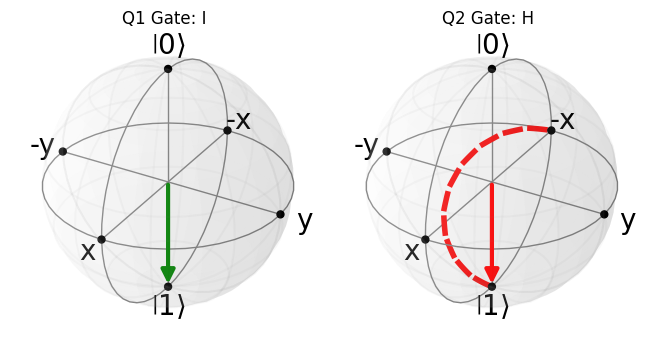

In [ ]:
#scaling to 2Q  #20231011 - method - scalable

wfig = 8.6
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d')
ax1 = fig.add_subplot(spec[0, 1], projection='3d')

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)
b1 = qutip.Bloch(axes=ax1)

#assuming state_arr is obtained from previous config file
#make a list of bloch spheres, list of animation lists and arrays of states per qubit
#we add color vector for distinction
bs_lst_2Q = [b0, b1]
arr_lst_2Q = [state_arr_q1_1, state_arr_q2_0]
arcs_lst_2Q = [state_anim_list_q1_1, state_anim_list_q2_0]
q_cols_2Q = ['g', 'r']
zlabel_2Q = [[r'$\left|0\right>$', r'$\left|1\right>$'],
             [r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_2Q = [[ax0, gate_names_q1_1], [ax1, gate_names_q2_0]]

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel=zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  gate_labels are list of [axes, gate_labels] according to the 1Q list
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  ax_dumb = []
  for m in range(len(bs_lst)):
    #m = 1 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
    # annotate gate on title. one can do arrays of labels.
    ax = gate_labels[m][0]
    ax.set_title('Q' + str(int(m+1)) + ' Gate: ' + gate_labels[m][1][j])
    ax_dumb.append(ax)
  # return gate_labels[:][0] has a problematic output not expected
  return ax_dumb

def init(bs_lst, qcols, gate_labels):
    ax_dumb = []
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
      #https://stackoverflow.com/questions/75492605/animate-labels-using-funcanimation-in-matplotlib
      ax = gate_labels[m][0] #retrieve selected axes depending on number of bloch sphere
      ax_dumb.append(ax)
    return ax_dumb

ani = animation.FuncAnimation(fig, partial(animate_add_vec, bs_lst=bs_lst_2Q,
 arr_lst=arr_lst_2Q,
 arcs_lst=arcs_lst_2Q,
 qcols=q_cols_2Q,
                                           zlabels=zlabel_2Q,
                                           gate_labels=glabel_2Q),
                              np.arange(len(arr_lst_2Q[0])),
                              init_func = partial(init, bs_lst_2Q, q_cols_2Q,
                                                  glabel_2Q),
                              repeat=False)
func_0 = '=|1>'
func_n = '_|0>_CCD'
fname = 'b_sphere_'+'2Q_'+purpose_1+func_0+'_q2t'+func_n+'.mp4' #with trajectory
ani.save(fname, fps=5)

#runtime: 26s

### Case where control Q1 = |1> and Q2 =|1> => |0>
(Reference: Two qubit gates qutech: https://www.youtube.com/watch?v=vwjlEdwi2LU)

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

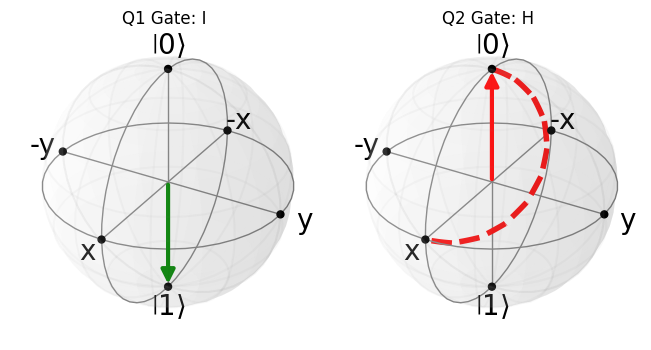

In [ ]:
#scaling to 2Q  #20231011 - method - scalable

wfig = 8.6
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d')
ax1 = fig.add_subplot(spec[0, 1], projection='3d')

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)
b1 = qutip.Bloch(axes=ax1)

#assuming state_arr is obtained from previous config file
#make a list of bloch spheres, list of animation lists and arrays of states per qubit
#we add color vector for distinction
bs_lst_2Q = [b0, b1]
arr_lst_2Q = [state_arr_q1_1, state_arr_q2_1]
arcs_lst_2Q = [state_anim_list_q1_1, state_anim_list_q2_1]
q_cols_2Q = ['g', 'r']
zlabel_2Q = [[r'$\left|0\right>$', r'$\left|1\right>$'],
             [r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_2Q = [[ax0, gate_names_q1_1], [ax1, gate_names_q2_1]]

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel=zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  gate_labels are list of [axes, gate_labels] according to the 1Q list
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  ax_dumb = []
  for m in range(len(bs_lst)):
    #m = 1 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
    # annotate gate on title. one can do arrays of labels.
    ax = gate_labels[m][0]
    ax.set_title('Q' + str(int(m+1)) + ' Gate: ' + gate_labels[m][1][j])
    ax_dumb.append(ax)
  # return gate_labels[:][0] has a problematic output not expected
  return ax_dumb

def init(bs_lst, qcols, gate_labels):
    ax_dumb = []
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
      #https://stackoverflow.com/questions/75492605/animate-labels-using-funcanimation-in-matplotlib
      ax = gate_labels[m][0] #retrieve selected axes depending on number of bloch sphere
      ax_dumb.append(ax)
    return ax_dumb

ani = animation.FuncAnimation(fig, partial(animate_add_vec, bs_lst=bs_lst_2Q,
 arr_lst=arr_lst_2Q,
 arcs_lst=arcs_lst_2Q,
 qcols=q_cols_2Q,
                                           zlabels=zlabel_2Q,
                                           gate_labels=glabel_2Q),
                              np.arange(len(arr_lst_2Q[0])),
                              init_func = partial(init, bs_lst_2Q, q_cols_2Q,
                                                  glabel_2Q),
                              repeat=False)
func_0 = '=|1>'
func_n = '_|1>_CCD'
fname = 'b_sphere_'+'2Q_'+purpose_1+func_0+'_q2t'+func_n+'.mp4' #with trajectory
ani.save(fname, fps=5)

#runtime: 27 s

In [ ]:
from qutip.ipynbtools import version_table
version_table() #this is good

Software,Version
QuTiP,4.7.3
Numpy,1.23.5
SciPy,1.11.3
matplotlib,3.7.1
Cython,3.0.3
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.34.0
Python,"3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]"
OS,posix [linux]
